In [341]:
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
from utils import to_json_friendly_tree, compute_param_tree_layer_norms


from expt_grokking_modulo_addition import (
    generate_modulo_dataset,
    create_model,
    ModuloMLP,
    data_generator,
    make_checkpoint_timestamps
)

from sgld_utils import (
    SGLDConfig,
    run_llc_estimation,
    generate_rngkey_tree
)


In [344]:

# Set up the configuration
config = {
    'data_config': {
        'p': 53,
        'train_frac': 0.4,
    },
    'model_config': {
        'embed_dim': 12,
        'hidden_size': 48,
    },
    'training_config': {
        'learning_rate': 0.003,
        'batch_size': 128, # 128,
        'num_steps': 30000,  # 
        'weight_decay': 0.0002, # 0.0002,
        'l1_reg': 0.000,
    }
}

# SGLD config for LLC estimation
sgld_config = SGLDConfig(
    epsilon= 0.03, #0.03,
    gamma=5.0, #5.0,
    num_steps=500,
    num_chains=2,
    batch_size=config['training_config']['batch_size'],
)

# Training settings
num_steps = config['training_config']['num_steps']
batch_size = config['training_config']['batch_size']
n_checkpoints = 100
logging_period = num_steps // n_checkpoints + (num_steps % n_checkpoints > 0)
burn_in_prop = 0.9


# Set random seed
seed = 0
key = jax.random.PRNGKey(seed)

# Generate dataset
key, data_key = jax.random.split(key)
train_data, test_data = generate_modulo_dataset(
    config['data_config']['p'],
    config['data_config']['p']**2,
    data_key,
    config['data_config']['train_frac']
)

x_train, y_train = train_data["features"], train_data["labels"]
assert np.all(x_train.sum(axis=1) % config['data_config']['p'] == y_train)
assert len(test_data["features"]) == config['data_config']['p']**2

In [345]:

# Create and initialize model
model = create_model(
    config['data_config']['p'],
    config['model_config']['embed_dim'],
    config['model_config']['hidden_size']
)

key, init_key = jax.random.split(key)
params = model.init(init_key, jnp.zeros((1, 2), dtype=jnp.int32))

# Set up optimizer
optimizer = optax.adam(
    learning_rate=config['training_config']['learning_rate'],
    b1=0.9,
    b2=0.999,
    eps=1e-8
)
opt_state = optimizer.init(params)

# Define training functions
@jax.jit
def loss_fn(params, x, y):
    logits = model.apply(params, None, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

def create_training_loss_fn(loss_fn, weight_decay=None, l1_reg=None):
    do_l1_reg = (l1_reg is not None) and (l1_reg > 0.0)
    do_l2_reg = (weight_decay is not None) and (weight_decay > 0.0)
    if do_l1_reg and do_l2_reg:
        def additional_term(params):
            l1_norm = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))
            l2_norm = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
            return 0.5 * weight_decay * l2_norm + l1_reg * l1_norm
    elif do_l1_reg:
        def additional_term(params):
            l1_norm = sum(jnp.sum(jnp.abs(p)) for p in jax.tree_util.tree_leaves(params))
            return l1_reg * l1_norm
    elif do_l2_reg:
        def additional_term(params):
            l2_norm = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
            return 0.5 * weight_decay * l2_norm
    else:
        def additional_term(params):
            return 0.0
    def training_loss_fn(params, x, y):
        return loss_fn(params, x, y) + additional_term(params)
    return training_loss_fn

training_loss_fn = create_training_loss_fn(
    loss_fn, 
    config['training_config']['weight_decay'], 
    config['training_config']['l1_reg']
)

@jax.jit
def compute_accuracy(params, x, y):
    logits = model.apply(params, None, x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

@jax.jit
def training_step(params, opt_state, x, y):
    loss_value, grads = jax.value_and_grad(training_loss_fn)(params, x, y)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value


def plot_prediction_heatmap(params, p=53):
    """Plot a heatmap of the model's predictions for all possible input pairs."""
    # Generate all possible pairs
    x1, x2 = np.meshgrid(np.arange(p), np.arange(p))
    all_pairs = np.stack([x1.flatten(), x2.flatten()], axis=1)
    
    # Get model predictions
    logits = model.apply(params, None, all_pairs)
    predictions = jnp.argmax(logits, axis=-1).reshape(p, p)
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(predictions, ax=ax)
    ax.set_title('Model Predictions')
    ax.set_xlabel('First Number')
    ax.set_ylabel('Second Number')
    return fig, ax


In [346]:

# Create data generator
key, gen_key = jax.random.split(key)
train_gen = data_generator(
    train_data['features'],
    train_data['labels'],
    batch_size,
    gen_key
)

# Initialize tracking
training_records = []
param = params  # Use the initialized params
step = 1

checkpoint_timestamps = make_checkpoint_timestamps(num_steps, logging_period, False)
print(f"Num checkpoints: {len(checkpoint_timestamps)}")

with tqdm(total=num_steps) as pbar:
    while step <= num_steps:
        # Training step
        x_batch, y_batch = next(train_gen)
        param, opt_state, loss = training_step(param, opt_state, x_batch, y_batch)
        
        if step in checkpoint_timestamps:
            # Compute metrics
            test_acc = compute_accuracy(param, test_data['features'], test_data['labels'])
            test_loss = loss_fn(param, test_data['features'], test_data['labels'])
            train_acc = compute_accuracy(param, train_data['features'], train_data['labels'])
            train_loss = loss_fn(param, train_data['features'], train_data['labels'])
            
            layer_norms = compute_param_tree_layer_norms(param)
            total_norm = sum(jax.tree.leaves(layer_norms))
            
            # Create record
            rec = {
                "step": step,
                "train_loss": float(train_loss),
                "test_loss": float(test_loss),
                "train_acc": float(train_acc),
                "test_acc": float(test_acc),
                "layer_norms": layer_norms,
            }
            
            # LLC estimation
            x_train = train_data['features']
            # y = jax.nn.softmax(model.apply(param, None, x_train))
            y = train_data['labels']
            
            key, subkey = jax.random.split(key)
            lambdahat_list, loss_traces = run_llc_estimation(
                subkey,
                loss_fn,
                sgld_config,
                param,
                x_train,
                y,
                itemp=2.0 / len(train_data['features']),
                loss_trace_minibatch=True,
                burn_in_prop=burn_in_prop,
                return_loss_trace=True
            )
            lambdahat = float(np.mean(lambdahat_list))
            
            rec.update({
                "llc_est": float(lambdahat),
                "llc_est_list": lambdahat_list,
                "loss_trace": loss_traces
            })
            
            training_records.append(rec)
            
            # Update progress bar
            pbar.update(step - pbar.n)
            pbar.set_postfix({
                'train_loss': f"{train_loss:.3f}",
                'test_loss': f"{test_loss:.3f}",
                'train_acc': f"{train_acc:.3f}",
                'test_acc': f"{test_acc:.3f}",
                'LLC': f"{lambdahat:.3f}"
            })
        
        step += 1
        if step > num_steps:
            break

Num checkpoints: 101


  0%|          | 0/30000 [00:00<?, ?it/s]

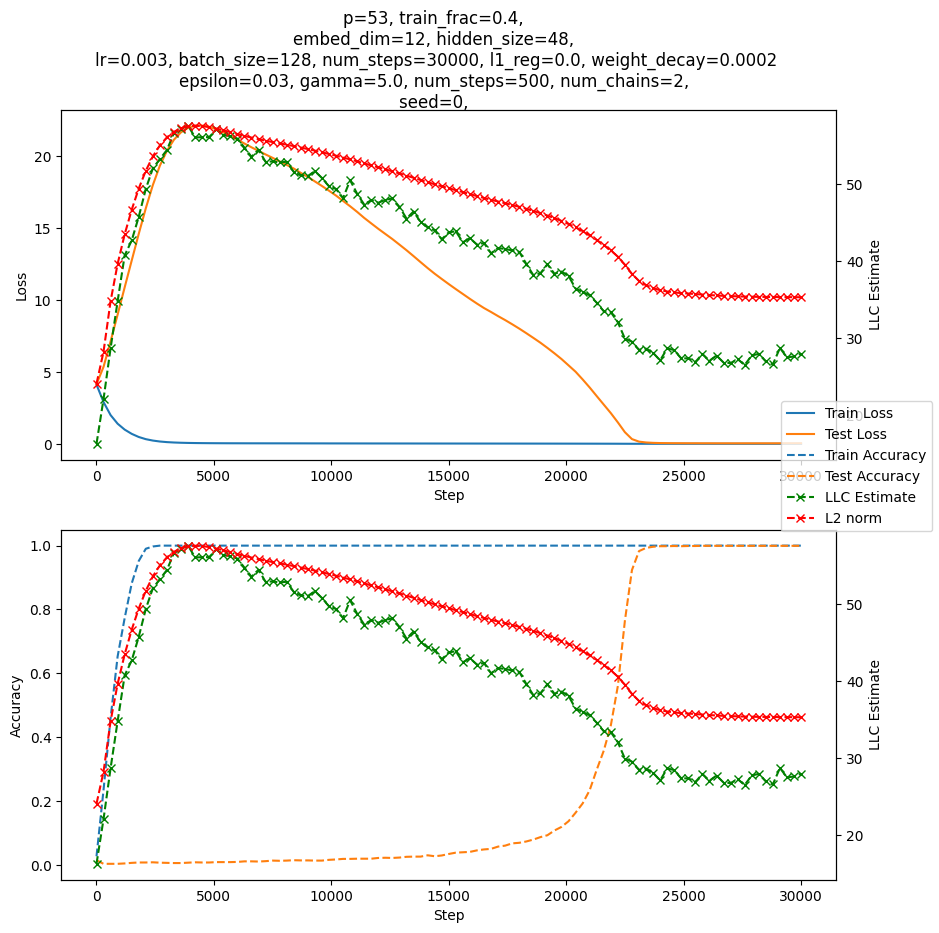

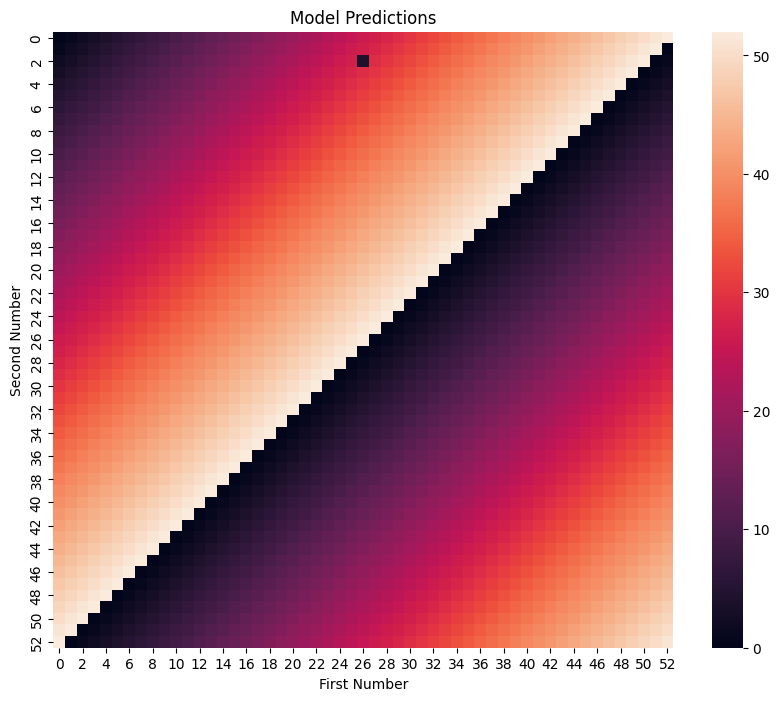

In [347]:
df_records = pd.DataFrame(training_records)
df_records["total_norm"]  = df_records["layer_norms"].apply(lambda x: np.sqrt(sum([val**2 for val in jax.tree.leaves(x)])))

fig, axes = plt.subplots(2, 1, figsize=(10, 10))
axes = axes.flatten()

# Loss plot
ax = axes[0]
ax.plot(df_records['step'], df_records['train_loss'], label='Train Loss')
ax.plot(df_records['step'], df_records['test_loss'], label='Test Loss')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
# ax.set_yscale('log')

ax = ax.twinx()
ax.plot(df_records['step'], df_records['llc_est'], "gx--", label='LLC Estimate')
ax.plot(df_records['step'], df_records['total_norm'], "rx--", label='L2 norm')
ax.set_ylabel('LLC Estimate')



# Accuracy plot
ax = axes[1]
ax.plot(df_records['step'], df_records['train_acc'], "--",  label='Train Accuracy')
ax.plot(df_records['step'], df_records['test_acc'], "--", label='Test Accuracy')
ax.set_xlabel('Step')
ax.set_ylabel('Accuracy')

ax = ax.twinx()
ax.plot(df_records['step'], df_records['llc_est'], "gx--")
ax.plot(df_records['step'], df_records['total_norm'], "rx--")
ax.set_ylabel('LLC Estimate')

fig.legend(loc='center right')

config_string = (
    f"p={config['data_config']['p']}, "
    f"train_frac={config['data_config']['train_frac']}, \n"
    f"embed_dim={config['model_config']['embed_dim']}, "
    f"hidden_size={config['model_config']['hidden_size']}, \n"
    f"lr={config['training_config']['learning_rate']}, "
    f"batch_size={config['training_config']['batch_size']}, "
    f"num_steps={config['training_config']['num_steps']}, "
    f"l1_reg={config['training_config']['l1_reg']}, "
    f"weight_decay={config['training_config']['weight_decay']}\n"
    f"epsilon={sgld_config.epsilon}, "
    f"gamma={sgld_config.gamma}, "
    f"num_steps={sgld_config.num_steps}, "
    f"num_chains={sgld_config.num_chains}, \n"
    f"seed={seed}, "
    
)
fig.suptitle(config_string)

plot_prediction_heatmap(param);

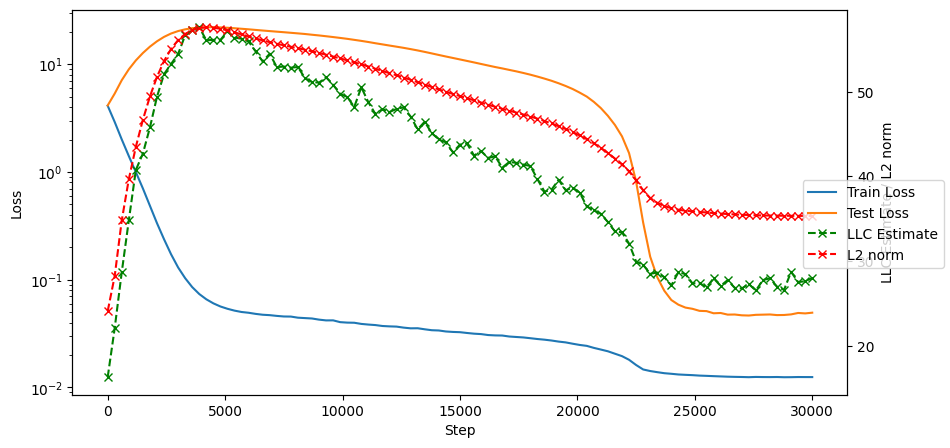

In [348]:
fig, ax = plt.subplots(figsize=(10, 5))
# loss plot in log scale
ax.plot(df_records['step'], df_records['train_loss'], label='Train Loss')
ax.plot(df_records['step'], df_records['test_loss'], label='Test Loss')
ax.set_xlabel('Step')
ax.set_ylabel('Loss')
ax.set_yscale('log')


ax = ax.twinx()
ax.plot(df_records['step'], df_records['llc_est'], "gx--", label='LLC Estimate')
ax.plot(df_records['step'], df_records['total_norm'], "rx--", label='L2 norm')
ax.set_ylabel('LLC Estimate / L2 norm')
fig.legend(loc='center right')

In [350]:
num_parameters = sum(np.prod(p.shape) for p in jax.tree.leaves(param))
num_parameters

4481

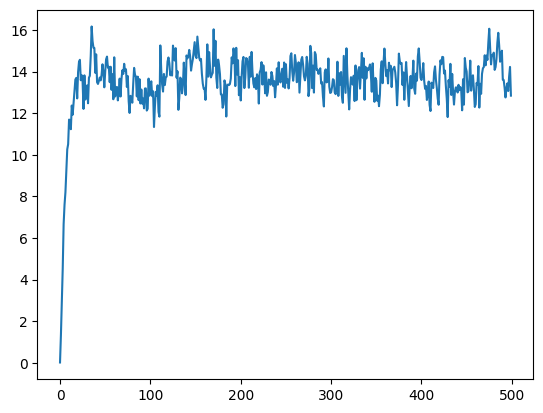

In [351]:
plt.plot(df_records["loss_trace"].iloc[-7].mean(axis=0), label="loss trace")

# Entropy-SGD

In [64]:
# Imports
import jax
import jax.numpy as jnp
import numpy as np
import haiku as hk
import optax
from entropy_sgd import EntropySGDConfig, entropy_sgd_grad, get_one_batch_of_data
from expt_grokking_modulo_addition import (
    generate_modulo_dataset,
    ModuloMLP,
    create_model
)

from sgld_utils import (
    SGLDConfig,
    run_llc_estimation,
    generate_rngkey_tree
)

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Configuration
p = 53
train_frac = 0.4
embed_dim = 12
hidden_size = 48
batch_size = 32
learning_rate = 0.01


esgd_config = EntropySGDConfig(
    sgld_steps=5,
    sgld_lr=0.1,
    sgld_noise=1e-3,
    initial_scope=1.0, # 1e-3,
    scope_increase=1.0, #1.001,
    ema_decay=0.75,
    batch_size=batch_size,
)

sgld_config = SGLDConfig(
    epsilon= 0.001, #0.03,
    gamma=5.0, #5.0,
    num_steps=800,
    num_chains=1,
    batch_size=batch_size,
)
burn_in_prop = 0.9

seed = 0
key = jax.random.PRNGKey(seed)

# Generate dataset
key, data_key = jax.random.split(key)
train_data, test_data = generate_modulo_dataset(p, p*p, data_key, train_frac)
train_features, train_labels = train_data['features'], train_data['labels']
test_features, test_labels = test_data['features'], test_data['labels']



# Create model and initialize parameters
model = create_model(p, embed_dim, hidden_size)
key, init_key = jax.random.split(key)
params = model.init(init_key, jnp.zeros((1, 2), dtype=jnp.int32))

# Define loss function
@jax.jit
def loss_fn(params: hk.Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    logits = model.apply(params, None, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

# Initialize Adam optimizer
# optimizer = optax.adam(learning_rate=learning_rate)
optimizer = optax.sgd(learning_rate=learning_rate, momentum=0.9)
opt_state = optimizer.init(params)

# Define accuracy function
@jax.jit
def compute_accuracy(params: hk.Params, x: jnp.ndarray, y: jnp.ndarray) -> float:
    logits = model.apply(params, None, x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

fileprefix = f"grokking_esgd_momentum_records_{p}_{train_frac}_{embed_dim}_{hidden_size}_{learning_rate}_{esgd_config.sgld_noise}_{esgd_config.initial_scope}_{esgd_config.scope_increase}_{esgd_config.sgld_steps}_{esgd_config.batch_size}_{sgld_config.epsilon}_{sgld_config.gamma}_{sgld_config.num_steps}_{sgld_config.num_chains}_{seed}"

In [217]:

@jax.jit
def make_step(params, features, labels, opt_state, rng_key, step):
    # Get Entropy-SGD gradients
    grads, new_key = entropy_sgd_grad(
        loss_fn,
        params,
        features,
        labels,
        rng_key,
        esgd_config,
        step
    )
    
    # Apply Adam updates
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    
    return new_params, new_opt_state, new_key

# Training loop
logging_period = 2000
llc_logging_period = 50 * logging_period

# num_steps = 20_000_000 + step
num_steps = 20_000_000
step = 0
records = [] 
param_best = params
test_acc_best = 0.0
while step < num_steps:
    
    key, subkey = jax.random.split(key)
    params, opt_state, key = make_step(
        params, train_features, train_labels, opt_state, key, step
    )
    step += 1
    
    if step % logging_period == 1:
        train_loss = loss_fn(params, train_features, train_labels)
        test_loss = loss_fn(params, test_features, test_labels)
        train_acc = compute_accuracy(params, train_features, train_labels)
        test_acc = compute_accuracy(params, test_features, test_labels)

        l2_norm = np.sqrt(sum(np.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)))
        print(
            f"Step {step}, "
            f"Loss: {train_loss:.12f}, Test loss: {test_loss:.4f}, " 
            f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.4f}, "
            f"l2_norm: {l2_norm:.4f}"
        )

        rec = {
            "step": step,
            "loss": float(train_loss),
            "test_loss": float(test_loss),
            "train_acc": float(train_acc),
            "test_acc": float(test_acc), 
            "l2_norm": float(l2_norm)
        }
        
        if test_acc > test_acc_best:
            test_acc_best = test_acc
            param_best = params
    
        if step % llc_logging_period == 1:
            x_train = train_data['features']
            y = train_data['labels']
            
            key, subkey = jax.random.split(key)
            lambdahat_list, loss_traces = run_llc_estimation(
                subkey,
                loss_fn,
                sgld_config,
                params,
                x_train,
                y,
                itemp=2.0 / len(train_data['features']),
                loss_trace_minibatch=True,
                burn_in_prop=burn_in_prop,
                return_loss_trace=True
            )
            lambdahat = float(np.mean(lambdahat_list))
            rec["lambdahat"] = lambdahat
            rec["params"] = params
            # rec["llc_trace"] = loss_traces
            print(f"Estimated LLC: {lambdahat:.4f}")
        records.append(rec)

Step 96910001, Loss: 0.000000000000, Test loss: 1889.5699, Train Acc: 1.000, Test Acc: 0.7903, l2_norm: 1031.8884
Step 96912001, Loss: 0.000000000000, Test loss: 1895.2039, Train Acc: 1.000, Test Acc: 0.7875, l2_norm: 1031.8903
Step 96914001, Loss: 0.000000000000, Test loss: 1892.0975, Train Acc: 1.000, Test Acc: 0.7875, l2_norm: 1031.9132
Step 96916001, Loss: 0.000000000000, Test loss: 1897.1353, Train Acc: 1.000, Test Acc: 0.7868, l2_norm: 1031.9594
Step 96918001, Loss: 0.000000000000, Test loss: 1895.3777, Train Acc: 1.000, Test Acc: 0.7875, l2_norm: 1031.9924
Step 96920001, Loss: 0.000000000000, Test loss: 1879.0844, Train Acc: 1.000, Test Acc: 0.7889, l2_norm: 1031.9954
Step 96922001, Loss: 0.000000000000, Test loss: 1877.1942, Train Acc: 1.000, Test Acc: 0.7896, l2_norm: 1031.9056
Step 96924001, Loss: 0.000000000000, Test loss: 1880.4039, Train Acc: 1.000, Test Acc: 0.7921, l2_norm: 1031.9021
Step 96926001, Loss: 0.000000000000, Test loss: 1878.4176, Train Acc: 1.000, Test Acc: 0

KeyboardInterrupt: 

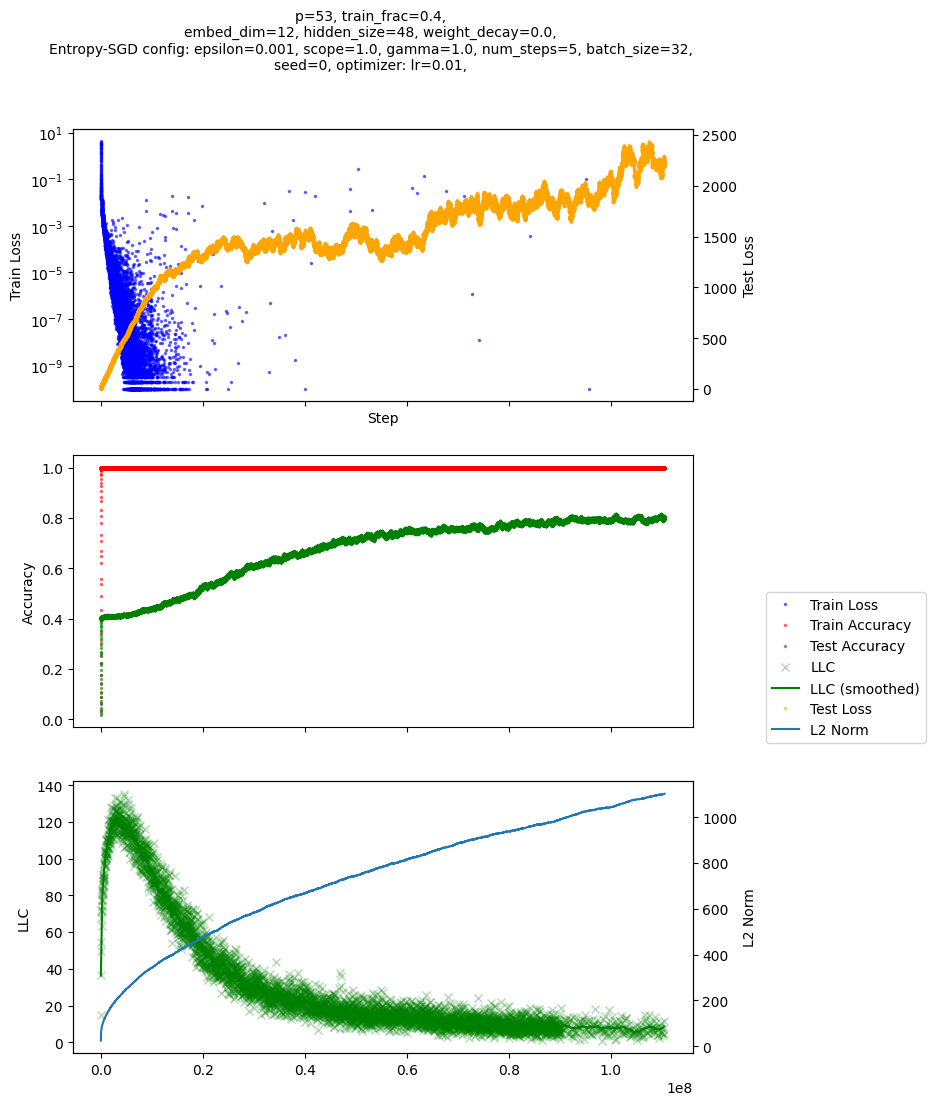

In [218]:
def running_mean(data, window_size=10):
    padded_data = np.pad(data, (window_size // 2, window_size // 2), mode="edge")
    output = np.convolve(padded_data, np.ones(window_size), mode="same") / window_size
    return output[window_size // 2:-window_size // 2]

marker_size = 3
df_records = pd.DataFrame(records)
# df_records = df_records[df_records["step"] > 100000]

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
ax = axes[0]
ax.plot(df_records['step'], df_records['loss'], "b.", label='Train Loss', markersize=marker_size, alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Train Loss')
ax.set_yscale('log')

ax = ax.twinx()
ax.plot(df_records['step'], df_records['test_loss'], ".", color="orange", label='Test Loss', markersize=marker_size, alpha=0.5)
ax.set_ylabel('Test Loss')



ax = axes[1]
ax.plot(df_records['step'], df_records['train_acc'], "r.", label='Train Accuracy', markersize=marker_size, alpha=0.5)
# ax.set_ylabel('Train Accuracy')
# ax = ax.twinx()
ax.plot(df_records['step'], df_records['test_acc'], "g.", label='Test Accuracy', markersize=marker_size, alpha=0.5)
# ax.set_ylabel('Test Accuracy')
ax.set_ylabel('Accuracy')


ax = axes[2]
ax.plot(df_records['step'], df_records["lambdahat"], "gx", label='LLC', alpha=0.3)
df = df_records[~df_records["lambdahat"].isna()]
ax.plot(df["step"], running_mean(df["lambdahat"], window_size=20), "g-", label="LLC (smoothed)")
ax.set_ylabel('LLC')
ax = ax.twinx()
ax.plot(df_records['step'], df_records['l2_norm'], label='L2 Norm')
ax.set_ylabel('L2 Norm')
ax.set_xlabel('Step')


fig.legend(bbox_to_anchor=(1.2, 0.5))
p = 53
suptitle = (
    f"p={p}, "
    f"train_frac={train_frac}, \n"
    f"embed_dim={embed_dim}, "
    f"hidden_size={hidden_size}, "
    f"weight_decay={0.0}, \n"
    "Entropy-SGD config: "
    f"epsilon={esgd_config.sgld_noise}, "
    f"scope={esgd_config.initial_scope}, "
    f"gamma={esgd_config.scope_increase}, "
    f"num_steps={esgd_config.sgld_steps}, "
    f"batch_size={esgd_config.batch_size}, \n"
    f"seed={seed}, "
    "optimizer: "
    f"lr={learning_rate}, "
)
fig.suptitle(suptitle, fontsize=10);

Text(0, 0.5, 'Second Number')

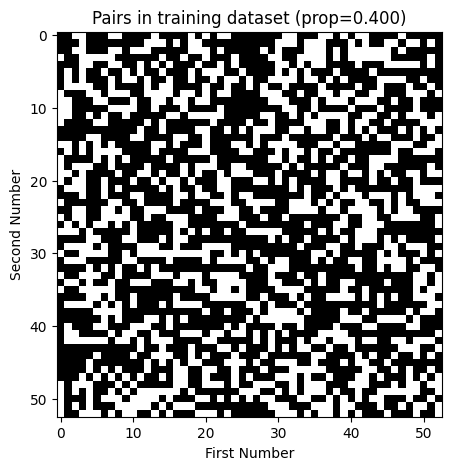

In [219]:
# displaying those pairs that are in the training dataset
x1, x2 = np.meshgrid(np.arange(p), np.arange(p))
all_pairs = np.stack([x1.flatten(), x2.flatten()], axis=1)

training_pairs = set(map(tuple, train_features.tolist()))
is_in_training = np.array([tuple(pair) in training_pairs for pair in all_pairs])
prop = is_in_training.mean()

fig, ax = plt.subplots(figsize=(5, 5))
# fig, ax = plot_prediction_heatmap(param_best)
ax.imshow(is_in_training.reshape(p, p), cmap='grey', alpha=1.0)
ax.set_title(f"Pairs in training dataset (prop={prop:.3f})")
ax.set_xlabel('First Number')
ax.set_ylabel('Second Number')



Text(0.5, 1.0, 'Average Prediction (p=53)')

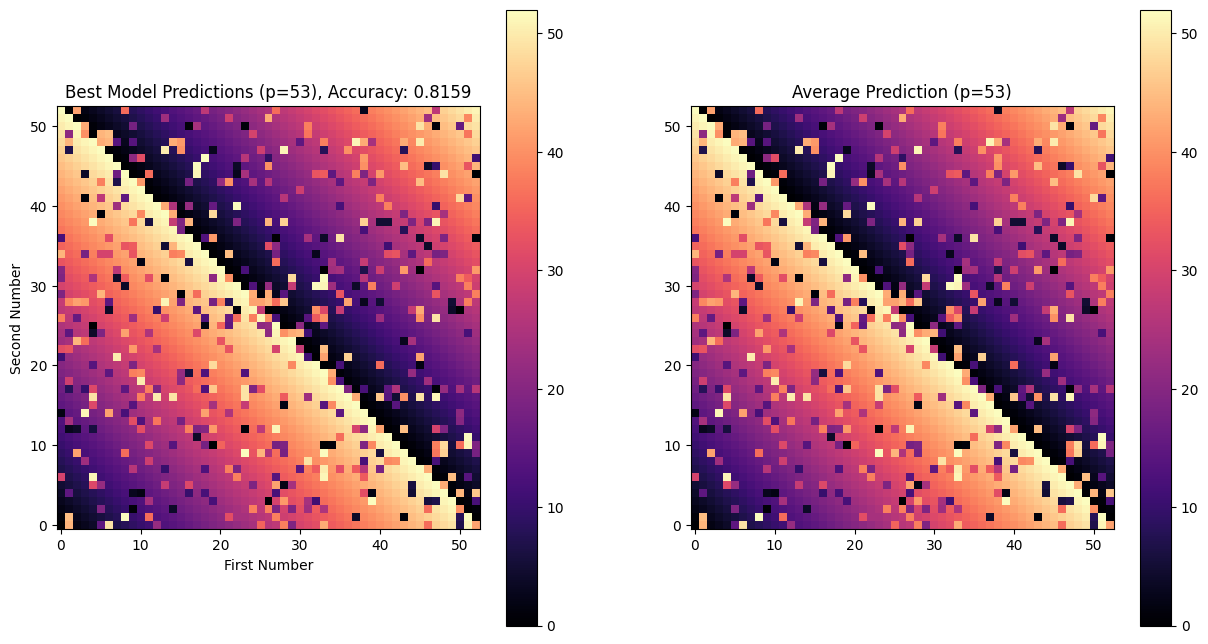

In [220]:

x1, x2 = np.meshgrid(np.arange(p), np.arange(p))
all_pairs = np.stack([x1.flatten(), x2.flatten()], axis=1)

# Get model predictions
logits = model.apply(param_best, None, all_pairs)
predictions = jnp.argmax(logits, axis=-1).reshape(p, p)

# Create heatmap
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
ax = axes[0]
# sns.heatmap(predictions, ax=ax)
cbar = ax.imshow(predictions, cmap='magma', origin='lower')
fig.colorbar(cbar)

ax.set_title(f"Best Model Predictions (p={p}), Accuracy: {test_acc_best:.4f}")
ax.set_xlabel('First Number')
ax.set_ylabel('Second Number');


probs = jax.nn.softmax(logits)
avg_pred = jnp.sum(probs * jnp.arange(p), axis=-1)
ax = axes[1]
cbar = ax.imshow(avg_pred.reshape(p, p), cmap='magma', origin='lower')
fig.colorbar(cbar)
ax.set_title(f"Average Prediction (p={p})")


Number of frames: 4578


/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


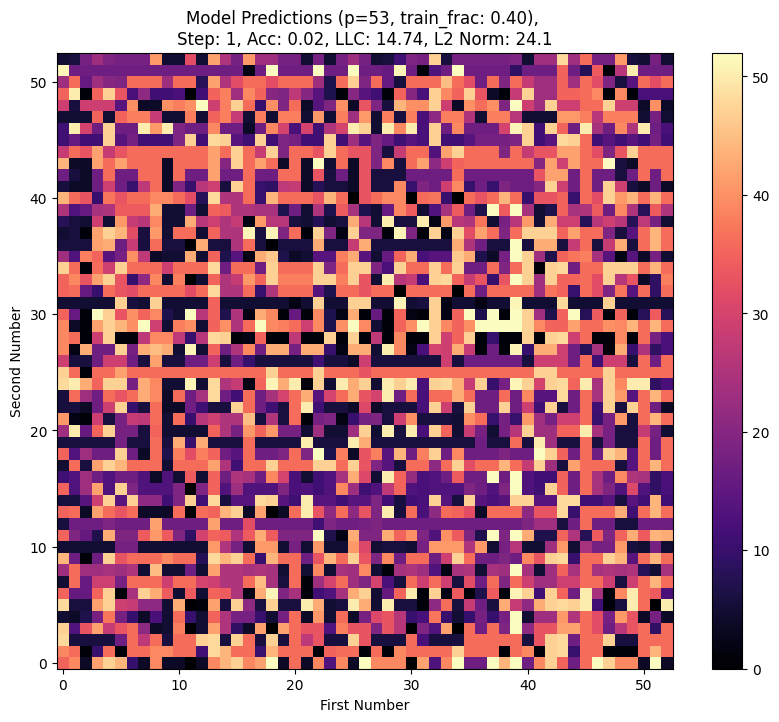

In [216]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

df = df_records[~df_records["lambdahat"].isna()]

def anim_func(frame_index):
    ax.clear()
    this_rec = df.iloc[frame_index]
    x1, x2 = np.meshgrid(np.arange(p), np.arange(p))
    all_pairs = np.stack([x1.flatten(), x2.flatten()], axis=1)
    logits = model.apply(this_rec["params"], None, all_pairs)
    predictions = jnp.argmax(logits, axis=-1).reshape(p, p)
    # predictions = jnp.sum(jax.nn.softmax(logits) * jnp.arange(p), axis=-1).reshape(p, p)
    ax.imshow(predictions, cmap="magma", origin="lower")
    ax.set_title(
        f"Model Predictions (p={p}, train_frac: {train_frac:.2f}), \n"
        f"Step: {this_rec['step']}, "
        f"Acc: {this_rec['test_acc']:.2f}, "
        f"LLC: {this_rec['lambdahat']:.2f}, "
        f"L2 Norm: {this_rec['l2_norm']:.1f}"
    )
    ax.set_xlabel('First Number')
    ax.set_ylabel('Second Number')
    return ax

fig, ax = plt.subplots(figsize=(10, 8))
num_frames = len(df)
# num_frames = 10
print(f"Number of frames: {num_frames}")
cbar = ax.imshow(predictions, cmap="magma", origin="lower")
fig.colorbar(cbar)
anim = FuncAnimation(fig, anim_func, frames=num_frames, interval=50)
filename = f"{fileprefix}_animation.mp4"
anim.save(filename, writer="ffmpeg", fps=10)
! open $filename

Text(0.5, 1.0, 'Predicted Probability Distribution for [21 14] = 35')

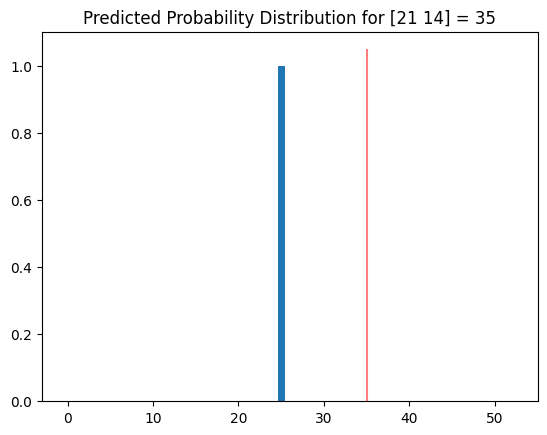

In [209]:
# logits = model.apply(param_best, None, test_features)
logits = model.apply(params, None, test_features)
probs = jax.nn.softmax(logits)


i = np.random.randint(len(test_features))
fig, ax = plt.subplots()
ax.bar(np.arange(p), probs[i])
ymin, ymax = ax.get_ylim()
ax.vlines(test_labels[i], ymin, ymax, color="r", alpha=0.5)
ax.set_title(f"Predicted Probability Distribution for {test_features[i]} = {test_labels[i]}")

In [211]:
df = df_records.copy(deep=True)
df["params"] = df["params"].apply(lambda x: jax.tree_util.tree_map(lambda y: y.tolist() if isinstance(y, jnp.ndarray) else None, x))
filename = f"{fileprefix}.csv"
df.to_csv(filename, index=False)

In [53]:
# recalculate LLC 
df = df_records.copy(deep=True)
df = df[~df["lambdahat"].isna()]

recalculated_llc = []
new_sgld_config = SGLDConfig(
    epsilon= 0.01,
    gamma=5.0, 
    num_steps=500,
    num_chains=2,
    batch_size=batch_size,
)
for i, row in df.iterrows():
    x_train = train_data['features']
    y = train_data['labels']

    key, subkey = jax.random.split(key)
    lambdahat_list, loss_traces = run_llc_estimation(
        subkey,
        loss_fn,
        new_sgld_config,
        row["params"],
        x_train,
        y,
        itemp=2.0 / len(train_data['features']),
        loss_trace_minibatch=True,
        burn_in_prop=burn_in_prop,
        return_loss_trace=True
    )
    lambdahat = float(np.mean(lambdahat_list))
    recalculated_llc.append((row["step"], lambdahat))
    print(f"Step {row['step']}, Estimated LLC: {lambdahat:.4f}")

Step 1, Estimated LLC: 16.3384
Step 20001, Estimated LLC: 53.6772
Step 40001, Estimated LLC: 67.4612
Step 60001, Estimated LLC: 79.7982
Step 80001, Estimated LLC: 86.3504
Step 100001, Estimated LLC: 85.7840
Step 120001, Estimated LLC: 80.3775
Step 140001, Estimated LLC: 72.5525
Step 160001, Estimated LLC: 79.4719
Step 180001, Estimated LLC: 72.2719
Step 200001, Estimated LLC: 70.7893
Step 220001, Estimated LLC: 69.7684
Step 240001, Estimated LLC: 67.2956
Step 260001, Estimated LLC: 57.4246
Step 280001, Estimated LLC: 57.1711
Step 300001, Estimated LLC: 52.5565
Step 320001, Estimated LLC: 49.1946
Step 340001, Estimated LLC: 49.1361
Step 360001, Estimated LLC: 46.2272
Step 380001, Estimated LLC: 46.5087
Step 400001, Estimated LLC: 43.0103
Step 420001, Estimated LLC: 43.4910
Step 440001, Estimated LLC: 36.8395
Step 460001, Estimated LLC: 38.6415
Step 480001, Estimated LLC: 38.0876
Step 500001, Estimated LLC: 35.6893
Step 520001, Estimated LLC: 35.4452
Step 540001, Estimated LLC: 33.5956
S

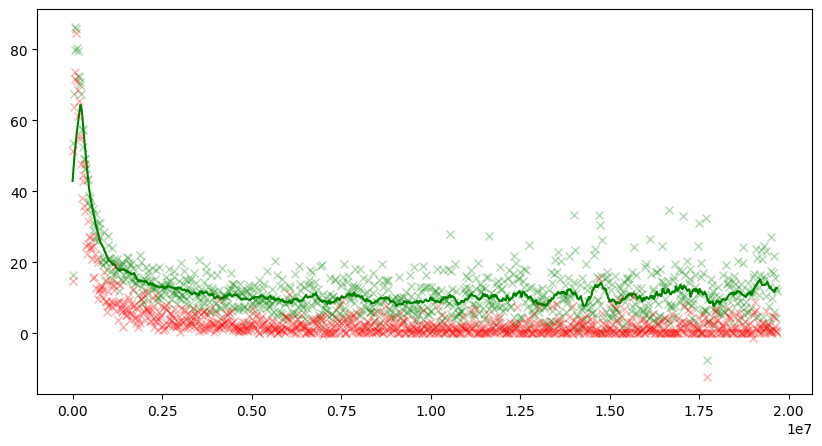

In [55]:
fig, ax = plt.subplots(figsize=(10, 5))
recalculated_llc = np.array(recalculated_llc)
ax.plot(recalculated_llc[:, 0], recalculated_llc[:, 1], "gx", label='LLC', alpha=0.3)
ax.plot(recalculated_llc[:, 0], running_mean(recalculated_llc[:, 1], window_size=20), "g-", label="LLC (smoothed)")

# original LLC
ax.plot(df_records['step'], df_records["lambdahat"], "rx", label='LLC', alpha=0.3)
ax.plot(df_records['step'], running_mean(df_records["lambdahat"], window_size=20), "r-", label='LLC', alpha=0.3)

In [268]:
from expt_grokking_modulo_addition import (
    data_generator,
    # create_transformer_model
)

# Configuration - adjusted for transformer architecture
p = 53  # modulus
train_frac = 0.4
embed_dim = 128  # increased from MLP since transformer needs more capacity
num_heads = 4  # number of attention heads
num_layers = 2  # number of transformer blocks
ff_dim = 256  # dimension of feed-forward network
batch_size = 32
learning_rate = 0.001  # reduced since transformer training can be more sensitive


sgld_config = SGLDConfig(
    epsilon= 0.01, #0.03,
    gamma=5.0, #5.0,
    num_steps=300,
    num_chains=1,
    batch_size=batch_size,
)
burn_in_prop = 0.9


seed = 0
key = jax.random.PRNGKey(seed)

# Generate dataset
key, data_key = jax.random.split(key)
train_data, test_data = generate_modulo_dataset(p, p*p, data_key, train_frac)
train_features, train_labels = train_data['features'], train_data['labels']
test_features, test_labels = test_data['features'], test_data['labels']

key, data_key = jax.random.split(key)
data_gen = data_generator(train_features, train_labels, batch_size, data_key)



# Create model and initialize parameters
model = create_transformer_model(p, embed_dim, num_heads, num_layers, ff_dim)
key, init_key = jax.random.split(key)
params = model.init(init_key, jnp.zeros((1, 2), dtype=jnp.int32))

@jax.jit
def loss_fn(params: hk.Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    logits = model.apply(params, None, x)
    return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()

l2_reg_coef = 0.005
# Define loss function
def create_loss_fn(l2_reg_coef):
    if (l2_reg_coef is not None) and (l2_reg_coef > 0.0):
        def training_loss_fn(params: hk.Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
            logits = model.apply(params, None, x)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
            l2_norm = sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
            l2_loss = 0.5 * l2_reg_coef * l2_norm
            return loss + l2_loss
        return training_loss_fn
    else:    
        return loss_fn
    

training_loss_fn = jax.jit(create_loss_fn(l2_reg_coef))


# The loss and accuracy functions remain the same since the model output format is identical
# Initialize optimizer - using Adam which typically works better for transformers
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# Training loop
@jax.jit
def train_step(params, opt_state, batch_x, batch_y):
    loss_value, grads = jax.value_and_grad(training_loss_fn)(params, batch_x, batch_y)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value


In [269]:

# Training loop
logging_period = 20
llc_logging_period = 5 * logging_period

num_steps = 10000
step = 0
records = [] 
param_best = params
test_acc_best = 0.0
while step < num_steps:
    batch_x, batch_y = next(data_gen)
    params, opt_state, loss_val = train_step(params, opt_state, batch_x, batch_y)
    step += 1
    
    if step % logging_period == 1:
        train_loss = loss_fn(params, train_features, train_labels)
        test_loss = loss_fn(params, test_features, test_labels)
        train_acc = compute_accuracy(params, train_features, train_labels)
        test_acc = compute_accuracy(params, test_features, test_labels)

        l2_norm = np.sqrt(sum(np.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params)))
        print(
            f"Step {step}, "
            f"Loss: {train_loss:.12f}, Test loss: {test_loss:.4f}, " 
            f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.4f}, "
            f"l2_norm: {l2_norm:.4f}"
        )

        rec = {
            "step": step,
            "loss": float(train_loss),
            "test_loss": float(test_loss),
            "train_acc": float(train_acc),
            "test_acc": float(test_acc), 
            "l2_norm": float(l2_norm)
        }
        
        if test_acc > test_acc_best:
            test_acc_best = test_acc
            param_best = params
    
        if step % llc_logging_period == 1:
            x_train = train_data['features']
            y = train_data['labels']
            
            key, subkey = jax.random.split(key)
            lambdahat_list, loss_traces = run_llc_estimation(
                subkey,
                loss_fn,
                sgld_config,
                params,
                x_train,
                y,
                itemp=1.0 / len(train_data['features']),
                loss_trace_minibatch=True,
                burn_in_prop=burn_in_prop,
                return_loss_trace=True
            )
            lambdahat = float(np.mean(lambdahat_list))
            rec["lambdahat"] = lambdahat
            rec["params"] = params
            rec["llc_trace"] = loss_traces
            print(f"Estimated LLC: {lambdahat:.4f}")
        records.append(rec)

Step 1, Loss: 4.304967403412, Test loss: 4.3102, Train Acc: 0.028, Test Acc: 0.0217, l2_norm: 86.4024
Estimated LLC: 8.3065
Step 21, Loss: 3.981975078583, Test loss: 4.0791, Train Acc: 0.034, Test Acc: 0.0217, l2_norm: 84.7780
Step 41, Loss: 3.985932588577, Test loss: 4.0461, Train Acc: 0.028, Test Acc: 0.0192, l2_norm: 82.9468
Step 61, Loss: 3.930779457092, Test loss: 4.0183, Train Acc: 0.033, Test Acc: 0.0199, l2_norm: 81.0483
Step 81, Loss: 3.942193269730, Test loss: 4.0790, Train Acc: 0.028, Test Acc: 0.0185, l2_norm: 79.1651
Step 101, Loss: 3.775934219360, Test loss: 4.0891, Train Acc: 0.071, Test Acc: 0.0299, l2_norm: 77.3605
Estimated LLC: 8.3544
Step 121, Loss: 3.724854707718, Test loss: 4.0740, Train Acc: 0.074, Test Acc: 0.0317, l2_norm: 75.7017
Step 141, Loss: 3.613182306290, Test loss: 4.1084, Train Acc: 0.094, Test Acc: 0.0384, l2_norm: 74.1434
Step 161, Loss: 3.532352209091, Test loss: 4.2191, Train Acc: 0.111, Test Acc: 0.0470, l2_norm: 72.7065
Step 181, Loss: 3.46881484

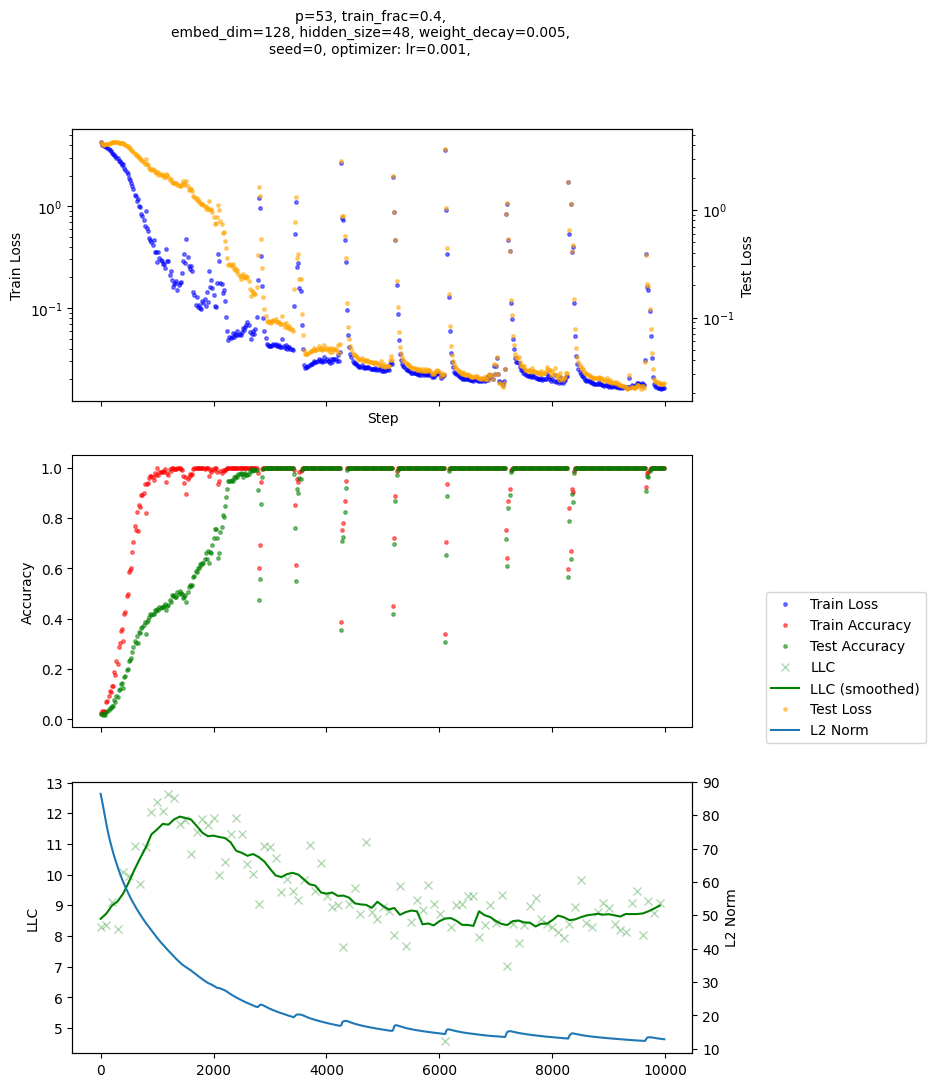

In [273]:
def running_mean(data, window_size=5):
    padded_data = np.pad(data, (window_size // 2, window_size // 2), mode="edge")
    output = np.convolve(padded_data, np.ones(window_size), mode="same") / window_size
    return output[window_size // 2:-window_size // 2]

marker_size = 5
df_records = pd.DataFrame(records)
# df_records = df_records[df_records["step"] > 100000]

fig, axes = plt.subplots(3, 1, figsize=(8, 12), sharex=True)
ax = axes[0]
ax.plot(df_records['step'], df_records['loss'], "b.", label='Train Loss', markersize=marker_size, alpha=0.5)
ax.set_xlabel('Step')
ax.set_ylabel('Train Loss')
ax.set_yscale('log')

ax = ax.twinx()
ax.plot(df_records['step'], df_records['test_loss'], ".", color="orange", label='Test Loss', markersize=marker_size, alpha=0.5)
ax.set_ylabel('Test Loss')
ax.set_yscale('log')



ax = axes[1]
ax.plot(df_records['step'], df_records['train_acc'], "r.", label='Train Accuracy', markersize=marker_size, alpha=0.5)
# ax.set_ylabel('Train Accuracy')
# ax = ax.twinx()
ax.plot(df_records['step'], df_records['test_acc'], "g.", label='Test Accuracy', markersize=marker_size, alpha=0.5)
# ax.set_ylabel('Test Accuracy')
ax.set_ylabel('Accuracy')


ax = axes[2]
ax.plot(df_records['step'], df_records["lambdahat"], "gx", label='LLC', alpha=0.3)
df = df_records[~df_records["lambdahat"].isna()]
ax.plot(df["step"], running_mean(df["lambdahat"], window_size=10), "g-", label="LLC (smoothed)")
ax.set_ylabel('LLC')
ax = ax.twinx()
ax.plot(df_records['step'], df_records['l2_norm'], label='L2 Norm')
ax.set_ylabel('L2 Norm')
ax.set_xlabel('Step')


fig.legend(bbox_to_anchor=(1.2, 0.5))
suptitle = (
    f"p={p}, "
    f"train_frac={train_frac}, \n"
    f"embed_dim={embed_dim}, "
    f"hidden_size={hidden_size}, "
    f"weight_decay={l2_reg_coef}, \n"
    # "Entropy-SGD config: "
    # f"epsilon={esgd_config.sgld_noise}, "
    # f"scope={esgd_config.initial_scope}, "
    # f"gamma={esgd_config.scope_increase}, "
    # f"num_steps={esgd_config.sgld_steps}, "
    # f"batch_size={esgd_config.batch_size}, \n"
    f"seed={seed}, "
    "optimizer: "
    f"lr={learning_rate}, "
)
fig.suptitle(suptitle, fontsize=10);

Number of parameters: 278837


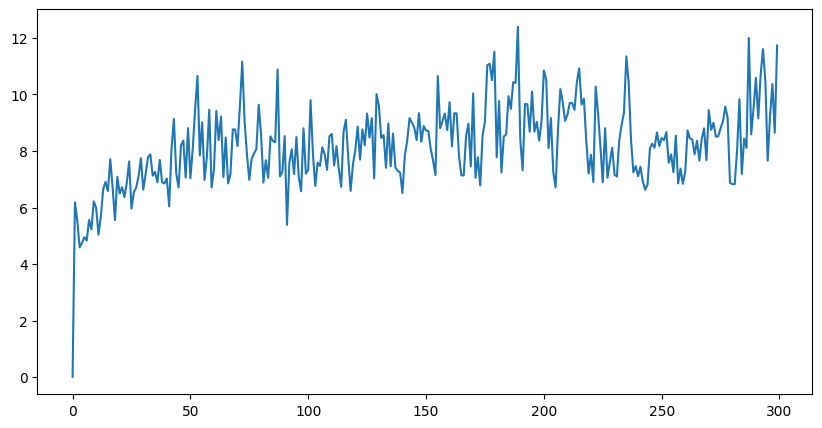

In [271]:
num_parameters = sum(np.prod(p.shapbe) for p in jax.tree.leaves(params))
print(f"Number of parameters: {num_parameters}")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_traces.mean(axis=0), lael="loss trace")

In [286]:
def gen_random_char(n):
    return ''.join(np.random.choice(list("ABCDEFGHIJKLMNOPQRSTUVWXYZ" + "  abcdefghijklmnopqrstuvwxyz0123456789"), n))
gen_random_char(100)

'BRBjff6NkY rKMzk92nft1CG1qFiCspVkRkfOSZmgOATrvHCByWSNKQypDwmNTWrzQBP5y3YbVhzlo1S9 FDxaLM SPLBoV1757K'